In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from tqdm.autonotebook import tqdm
import os
import cftime
import json
from dask import array

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20, interval='2s')
client = Client(cluster)
client

distributed.dashboard.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.48.160.10:38875
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-eb69a25c-6dfb-11ea-8210-0a2b65f2e791
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.48.160.10:38875 Dashboard: /user/ghall3-pangeo_tests-65pk03ig/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
gcs = gcsfs.GCSFileSystem(token='anon')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrss,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN


In [4]:
dfs = pd.read_csv('pangeo.csv')

In [5]:
# file_attrs = json.load(open('file_attrs.txt','r'))
# all_attrs = set(['_'.join([a['source_id'],a['member_id'],a['experiment_id'],a['table_id'],a['variable_id']]) for a in file_attrs])

# def want(s, m, e, t, v):
#     key = s+'_'+m+'_'+e+'_'+t+'_'+v
#     return s+'_'+m+'_'+e+'_'+t+'_'+v

# dfs = df[df[['source_id','member_id','experiment_id','table_id','variable_id']].apply(lambda x: want(*x) in all_attrs, axis=1)]

# pangeo_attrs = set(dfs[['source_id','member_id','experiment_id','table_id','variable_id']].apply(lambda x: want(*x), axis=1).values)
# manual_attrs = [a for a in all_attrs if a not in pangeo_attrs]
# json.dump(list(pangeo_attrs), open('pangeo_loads.txt', 'w'))
# json.dump(list(manual_attrs), open('manual_loads.txt', 'w'))

# dfs.to_csv('pangeo_loads.csv')

In [6]:
def load_srch_data(df, source_id, expt_id):

    uri = df[(df.source_id == source_id) &
                         (df.experiment_id == expt_id)].zstore.values[0]
    
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

def load_data(series):
    ds = xr.open_zarr(gcs.get_mapper(series.zstore), consolidated=True)
    return ds

def get_dims(ds):
    ds_coords = [l for l in list(ds.coords.keys()) if 'bnds' not in l and 'vert' not in l]
    dims = [[l for l in ds_coords if 'lat' in l][0], [l for l in ds_coords if 'lon' in l][0]]
    lon = ds.coords.get(dims[0])
    lat = ds.coords.get(dims[1])
    return lat, lon

def get_area(ds, df):
    var = ds.get(ds.variable_id)
    realm = ds.table_id[0].lower()
    lat, lon = get_dims(ds)

    df_area = df.query("variable_id == 'areacell"+realm+"' & source_id == '"+ds.source_id+"'")
    if len(df_area.zstore.values) == 0:
        if len(lat) > 1000:
            area = lat
            dims = ["ncells"]
            total_area = lat.sum()
        time, lon, area = np.meshgrid(ds.time, lon, np.cos(lat), indexing='ij')
        total_area = area[0,:,:].sum()
    else:
        ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
        area = ds_area.get("areacell"+realm)
        total_area = area.sum([lat.name, lon.name])

    return area, [lat.name, lon.name], total_area

def avg_var(ds, df):
    area, dims, total_area = get_area(ds, df)
    var = ds.get(ds.variable_id)
    
    ta_timeseries = (var * area).sum(dim=[d.name for d in dims]) / total_area
    
    if isinstance(ta_timeseries, type(None)):
        print('failed')
    return ta_timeseries



In [7]:
results = {}

distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.161.40:33959', name: 0, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.161.40:33959
distributed.core - INFO - Starting established connection


In [8]:
for num in tqdm(list(range(len(dfs)))):
    s = dfs.iloc[num]
    name = '_'.join([s.source_id, s.experiment_id, s.member_id, s.variable_id])
    if name in below_avg[:,0]:
        ds = load_data(s)
        break
    
    if s.table_id == 'Amon' or name + '.npy' in os.listdir('data') or 'EC-Earth3' in s.source_id:
        continue
        
    print(str(num),':',name)
    
    ds = load_data(s)
    if ds.experiment_id == 'piControl' or ds.experiment_id == '1pctCO2':
        ds = ds.sel(time=slice(ds.time[0], ds.time[min([1799, len(ds.time)-1])]))
    elif len(ds.time) > 2400:
        ds = ds.sel(time=slice(ds.time[0], ds.time[2399]))
    m = avg_var(ds, df)

    if not isinstance(m, type(None)):
        np.save('data/'+name, np.array([m.values[:], np.array([np.datetime64(t) for t in m.time.values])[:]]))

NameError: name 'below_avg' is not defined

Plot 30-year moving average $\Delta T$  for 1pctCO2 runs
=======

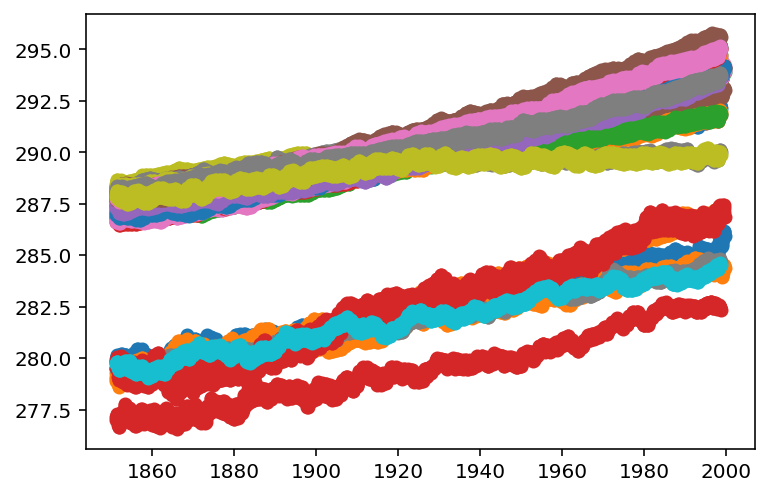

In [137]:
ns = np.array([[f, np.load('data/'+f, allow_pickle = True)] for f in os.listdir('data') if "1pctCO2" in f and '_ts.npy' in f])
below_ts = np.array([n for n in ns if np.mean(n[1][0]) < 200])
dates = [pd.to_datetime(n[1], errors='coerce') for n in ns[:,1]][0]
plt.figure("1pctCO2 runs")
for f, n in ns:
    if not isinstance(n[1,0], type(int)) and f not in below_ts[:,0]:
        w = 30
        plt.plot_date(dates[int(w/2)-1:int(len(n[0])-w/2)],
                      moving_average(n[0], w),
                      xdate=True)

Plot 30-year moving average $\Delta T$  for abrupt-4x runs
=======

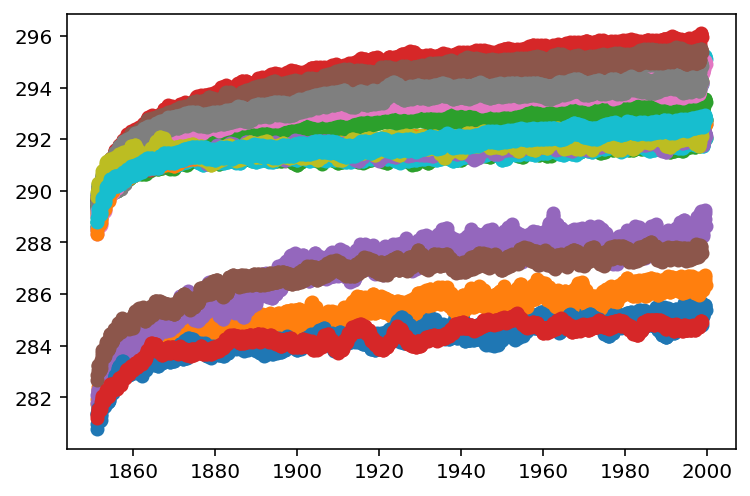

In [175]:
ns = np.array([[f, np.load('data/'+f, allow_pickle = True)] for f in os.listdir('data') if "abrupt" in f and '_ts.npy' in f])
below_ts = np.array([n[0] for n in ns if np.mean(n[1][0]) < 200])
short_ts = np.array([n[0] for n in ns if len(n[1][1]) < 1700])
dates = [d for d in [pd.to_datetime(n[1], errors='coerce') for n in ns[:,1]] if d[0] != 'NaT']
plt.figure("1pctCO2 runs")
for f, n in ns:
    if f not in below_ts and f not in short_ts:
        w = 30
        d = next(d for d in dates if len(d) == len(n[0]))
        plt.plot_date(d[int(w/2)-1:int(len(n[0])-w/2)],
                      moving_average(n[0], w),
                      xdate=True)

In [173]:
np.shape(dates[0])

(1812,)

In [ ]:
def percentiles(ds, df):
    Area = get_area(ds, df)
    Var = ds.get(ds.variable_id)
    
    percentiles = []
    
    for t in range(len(Var.time)):
        area = Area[t]
        var = Var[t]
        time = Var.time[t]
        
        weights = np.reshape(area.data, (np.prod(np.shape(var)),1))
        vals = np.reshape(var.data, (np.prod(np.shape(var)),1))
        weights = np.array(weights[~np.isnan(vals)])
        vals = np.array(vals[~np.isnan(vals)])

        idx = np.argsort(vals)
        vals = np.take_along_axis(vals, idx, axis=0)
        sorted_weights = np.array(np.take_along_axis(weights, idx, axis=0))
        total = np.nansum(weights)

        i = 0
        low = 0
        N = len(weights)
        pcts = np.array([0.05, 0.17, 0.5, 0.83, 0.95])
        pct_vals = []
        for j in range(0,len(vals)):
            low = low + sorted_weights[j]
            high = low + sorted_weights[min(j+1,N)]
            # If the cumulative weights are nearest the next percentile
            # Then mark down the value
            if low/total < pcts[i] and high/total >= pcts[i]:
                pct_vals += [[pcts[i], vals[j]]]
                if i == np.shape(pcts)[0] - 1:
                    break
                i = i + 1
                
        percentiles += [time, pct_vals]
    
    return percentiles


In [78]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w    

In [152]:
get_dims(ds)

<xarray.DataArray 'lon' (lon: 192)>
array([  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,  11.25 ,  13.125,
        15.   ,  16.875,  18.75 ,  20.625,  22.5  ,  24.375,  26.25 ,  28.125,
        30.   ,  31.875,  33.75 ,  35.625,  37.5  ,  39.375,  41.25 ,  43.125,
        45.   ,  46.875,  48.75 ,  50.625,  52.5  ,  54.375,  56.25 ,  58.125,
        60.   ,  61.875,  63.75 ,  65.625,  67.5  ,  69.375,  71.25 ,  73.125,
        75.   ,  76.875,  78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,
        90.   ,  91.875,  93.75 ,  95.625,  97.5  ,  99.375, 101.25 , 103.125,
       105.   , 106.875, 108.75 , 110.625, 112.5  , 114.375, 116.25 , 118.125,
       120.   , 121.875, 123.75 , 125.625, 127.5  , 129.375, 131.25 , 133.125,
       135.   , 136.875, 138.75 , 140.625, 142.5  , 144.375, 146.25 , 148.125,
       150.   , 151.875, 153.75 , 155.625, 157.5  , 159.375, 161.25 , 163.125,
       165.   , 166.875, 168.75 , 170.625, 172.5  , 174.375, 176.25 , 178.125,
       180.   , 181.875, 183.75 , 185.625, 187.5  , 189.375, 191.25 , 193.125,
       195.   , 196.875, 198.75 , 200.625, 202.5  , 204.375, 206.25 , 208.125,
       210.   , 211.875, 213.75 , 215.625, 217.5  , 219.375, 221.25 , 223.125,
       225.   , 226.875, 228.75 , 230.625, 232.5  , 234.375, 236.25 , 238.125,
       240.   , 241.875, 243.75 , 245.625, 247.5  , 249.375, 251.25 , 253.125,
       255.   , 256.875, 258.75 , 260.625, 262.5  , 264.375, 266.25 , 268.125,
       270.   , 271.875, 273.75 , 275.625, 277.5  , 279.375, 281.25 , 283.125,
       285.   , 286.875, 288.75 , 290.625, 292.5  , 294.375, 296.25 , 298.125,
       300.   , 301.875, 303.75 , 305.625, 307.5  , 309.375, 311.25 , 313.125,
       315.   , 316.875, 318.75 , 320.625, 322.5  , 324.375, 326.25 , 328.125,
       330.   , 331.875, 333.75 , 335.625, 337.5  , 339.375, 341.25 , 343.125,
       345.   , 346.875, 348.75 , 350.625, 352.5  , 354.375, 356.25 , 358.125])
Coordinates:
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    axis:           X
    bounds:         lon_bnds
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east